## Spandan Pandya: Computational Astrophysics and Geophysics Assignment 1

In [1]:
#Relevant Libraries
import numpy as np 
import matplotlib.pyplot as plt
from numba import njit #to speed up code 

## Solving the Kepler Orbit Using Euler Integration

In [2]:
@njit
def kepler(t,x,y):
        r2=(x**2+y**2) #calculate the square of radius
        G=6.67430e-11 #Gravitational constant
        M=5.972e24 #Mass of the Earth 
        a_x=-G*M*x/r2**(1.5) #acceleration in x direction
        a_y=-G*M*y/r2**(1.5) #acceleration in y direction
        return a_x,a_y
@njit
def euler_solve(tf,h):
    N=int(tf/h)
    x=np.zeros(N)
    y=np.zeros(N)
    vx=np.zeros(N)
    vy=np.zeros(N)
    time=np.zeros(N)

    x[0]=-6678000
    y[0]=0
    vy[0]=-8000
    vx[0]=0
    #Euler conditions
    for i in range(N-1):
        time[i+1]=time[i]+h
        vx[i+1]=vx[i]+h*kepler(time[i],x[i],y[i])[0]
        vy[i+1]=vy[i]+h*kepler(time[i],x[i],y[i])[1]
        x[i+1]=x[i]+h*vx[i]
        y[i+1]=y[i]+h*vy[i]
        
    return x,y,vx,vy,time


In [3]:
%%time
#one orbit
xu,yu,vxu,vyu,timeu=euler_solve(6500,0.01)

CPU times: user 288 ms, sys: 22.2 ms, total: 310 ms
Wall time: 368 ms


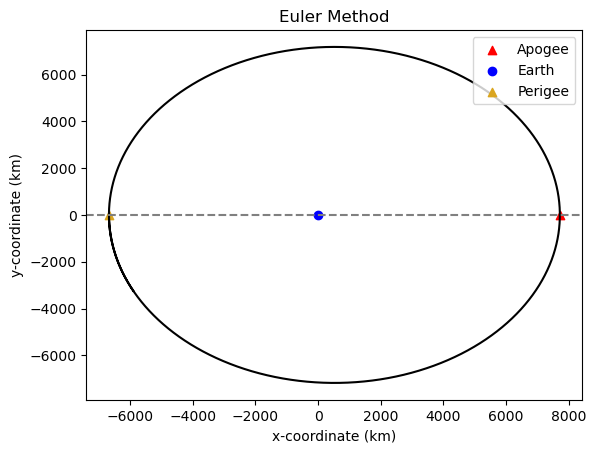

In [4]:
#Plotting
plt.plot(xu/1000,yu/1000,lw=1.5,c='k')
plt.scatter(max(xu/1000),0,c='red',label='Apogee',marker="^")
plt.scatter(0,0,c='blue',label='Earth')
plt.scatter(-6678,0,c='goldenrod',label='Perigee',marker="^")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.ticklabel_format(style='sci', axis='both', scilimits=(-1e6,1e6))
plt.legend(loc='upper right')
plt.axhline(0,ls='--',c='grey')
plt.title('Euler Method')
plt.show()

## Solving the Kepler Orbit Using RK4 Integrator

In [5]:
def f(r, t): #takes the vector r comprising of velocities and positions
        x = r[0] #the first component gives cartesian coordinate x
        y=r[1] #the second coordinate gives cartesian coordinate y
        r2=(x**2+y**2) #calculate the square of radius
        G=6.67430e-11 #Gravitational constant
        M=5.972e24 #Mass of the Earth 
        a_x=-G*M*x/r2**(1.5) #acceleration in x direction
        a_y=-G*M*y/r2**(1.5) #acceleration in y direction
        vx=r[2] #x-velocity taken from r vector
        vy=r[3] #y-velocity taken from r vector
        dxdt=vx #defining first order DE
        dydt=vy #First order DE
        dvydt=a_y #solving for velocities
        dvxdt=a_x #solving for velocities
        return np.array([dxdt,dydt,dvxdt,dvydt], dtype=float)


def Rk4Orbit(b,h): #takes endpoint of integral and stepsize as input
    R=6378000 #Radius of earth for other values 

    a = 0.0 #initial time for integration
    N=int((b-a)/h) #Number of datapoints

    #Initializing empty arrays
    time=np.zeros(N)
    x=np.zeros(N)
    y=np.zeros(N)
    vx=np.zeros(N)
    vy=np.zeros(N)

    #Initial conditions for the integrations
    r = np.array([-6678000,0,0,-8000], dtype=float) #x,y,vx,vy 
    #Coordinates chosen such that the centre is earth.

    for i in range(N):
        time[i]= time[i-1]+h #create a time array
        x[i]=(r[0]) #add to position array x
        y[i]=(r[1]) #add to position array y
        vx[i]=(r[2]) #add to x-velocity
        vy[i]=(r[3]) #add to y-velocity
        #Implementation of RK4 Rules:
        k1 = h * f(r, time[i]) 
        k2 = h * f(r + 0.5 * k1, time[i] + 0.5 * h)
        k3 = h * f(r + 0.5 * k2, time[i] + 0.5 * h)
        k4 = h * f(r + k3, time[i] + h)
        r  += (k1 + 2 * k2 + 2 * k3 + k4) / 6
    
    return time,x,y,vx,vy

In [6]:
%%time
time,x,y,vx,vy=Rk4Orbit(6500,100)

CPU times: user 3.98 ms, sys: 2.56 ms, total: 6.54 ms
Wall time: 955 µs


## Plotting the Orbits

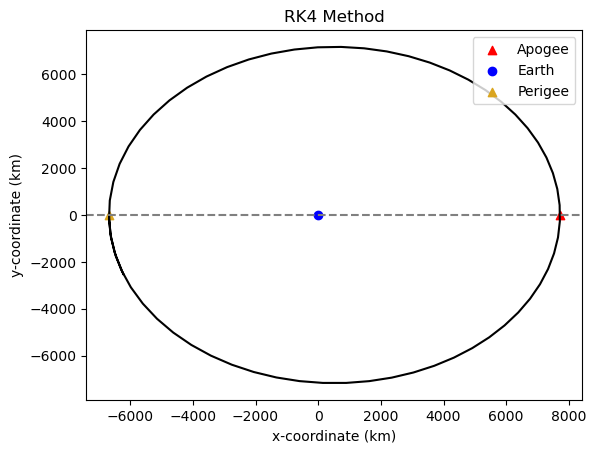

In [7]:
plt.plot(x/1000,y/1000,lw=1.5,c='k')
plt.scatter(max(x/1000),0,c='red',label='Apogee',marker="^")
plt.scatter(0,0,c='blue',label='Earth')
plt.scatter(-6678,0,c='goldenrod',label='Perigee',marker="^")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.ticklabel_format(style='sci', axis='both', scilimits=(-1e6,1e6))
plt.legend(loc='upper right')
plt.axhline(0,ls='--',c='grey')
plt.title('RK4 Method')

plt.show()

## Solving the Kepler Orbit Using Stoermer’s Rule for Conservative Equations

In [8]:
@njit
def f_BS(u,t): #u is the x,y vector, t is the time
    x=u[0] #cartesian coordinates
    y=u[1]
    r2=(x**2+y**2) #square of r
    G=6.67430e-11 #constants
    M=5.972e24
    a_x=-G*M*x/r2**(1.5)
    a_y=-G*M*y/r2**(1.5)
    return np.array([a_x,a_y],dtype=np.float64) #gives y''(x)

@njit
def Stoermer_Midpoints(H,m,tf): #H is the larger stepsize, 
                                #m is the number of points along larger steps
                                #tf is the final integration time 
    k=0 #initializing steps of H
    t=0 #initializing time
#for this algorithm we require z0 which is the derivatives (velocities) and y0 which are positions
    u0=np.array([-6678000,0],dtype=np.float64) #initial displacements along x and y
    z0=np.array([0,-8000],dtype=np.float64) #initial velocities along x and y 
    N=int(tf/H) #number of positions and velocities to store 
    h=H/m #smaller step size which moves in the subpoints along large H
    d0=h*(z0 + h*f_BS(u0,t)/2) #initializing differences in y values to avoid round off errrors

    #initializing storage arrays
    t1=np.zeros(N)
    x1=np.zeros(N)
    y1=np.zeros(N)
    vx1=np.zeros(N)
    vy1=np.zeros(N)

    for _ in range(N):
        #store all values in array
        t1[k]+=t 
        x1[k]=u0[0]
        y1[k]=u0[1]
        vx1[k]=z0[0]
        vy1[k]=z0[1]
        #we have 
        u1=u0+d0
        d_m=np.zeros((m,2))
        d_m[0]=d0
        Y_m=np.zeros((m+1,2))
        Y_m[0]=u0
        Y_m[1]=u1
        for i in range(1,m):
            #d_m.append(d_m[i-1]+h**2*f_BS(u0,t+i*h))
            d_m[i]=d_m[i-1]+h**2*f_BS(u0,t+i*h)
            Y_m[i+1]=Y_m[i]+d_m[i]
            #Y_m.append(Y_m[i]+d_m[i])   
        z0=d_m[-1]/h+0.5*h*f_BS(Y_m[-1],t+H)
        u0=Y_m[-1]
        d0=h*(z0 + h*f_BS(u0,t+H)/2)
        k+=1
        t=t+H 
    return t1,x1,y1,vx1,vy1

In [9]:
%%time
#1 orbit
t1,x1,y1,vx1,vy1=Stoermer_Midpoints(0.004,2,6500)

CPU times: user 1.63 s, sys: 238 ms, total: 1.87 s
Wall time: 951 ms


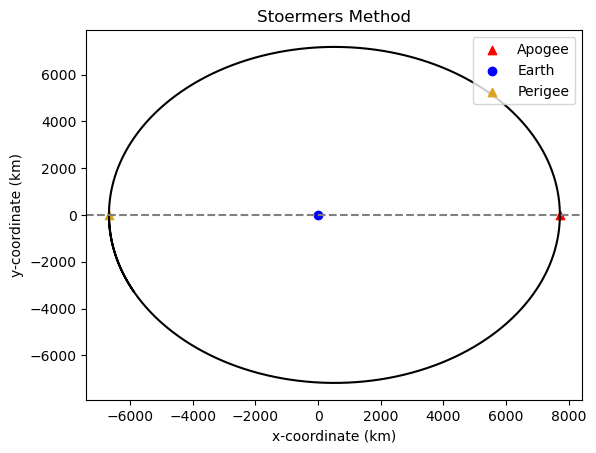

In [10]:
#PLOTTING
plt.plot(x1/1000,y1/1000,lw=1.5,c='k')
plt.scatter(max(x1/1000),0,c='red',label='Apogee',marker="^")
plt.scatter(0,0,c='blue',label='Earth')
plt.scatter(-6678,0,c='goldenrod',label='Perigee',marker="^")
plt.xlabel('x-coordinate (km)')
plt.ylabel('y-coordinate (km)')
plt.ticklabel_format(style='sci', axis='both', scilimits=(-1e6,1e6))
plt.legend(loc='upper right')
plt.axhline(0,ls='--',c='grey')
plt.title('Stoermers Method')

plt.show()

## Finding the Apogee Values in All Methods

Apogee Occurs when the satellite is farthest away along x (as a result of coordinate choice). This should again be on the $y=0$ line. Note that due to integration errors, the coordinate of y is not exactly 0 but very close. 

In [11]:
#Finding apogee numerically by approximating when x=0
print('The Apogee as found from the RK4 method gives: ',np.round(max(x)/1000,0),'km Which is',np.round(max(x)/1000-6378,0), 'km from the edge of earth')
print('The Apogee as found from the Stoermer method gives: ',np.round(max(x1)/1000,0),'km Which is',np.round(max(x1)/1000-6378,0), 'km from the edge of earth')
print('The Apogee as found from the Euler method gives: ',np.round(max(xu)/1000,0),'km Which is',np.round(max(xu)/1000-6378,0), 'km from the edge of earth')

The Apogee as found from the RK4 method gives:  7713.0 km Which is 1335.0 km from the edge of earth
The Apogee as found from the Stoermer method gives:  7718.0 km Which is 1340.0 km from the edge of earth
The Apogee as found from the Euler method gives:  7719.0 km Which is 1341.0 km from the edge of earth


These expressions match the analytically expected apogee value. 

## Finding Time Periods in both Methods

The time period can be found by plotting time versus x and y graphs. The point at which both return to their starting values once gives us an estimate of the time period of oscillation. The way we find this time period is by finding when it reaches $x=-6678000$ m again in time and $y=0$ m. Numerically, we will once again not get the exact value but will get the closest value of $x$ and $y$ to what we anticipate. 

#### RK4

In [12]:
Rk_indx=0
Rk_indy=0
x0=-6678000
a=x-x0
mini=min(a[1:])
for i in range(len(x)):
    if a[i]==mini:
        print('The x-time period is',time[i],'s with index',i)
        Rk_indx+=i

miny=min(abs(y[int(len(y)/2):]))
for i in range(len(y)):
    if abs(y[i])==miny:
        print('The y-time period is',time[i],'s with index',i)
        Rk_indy+=i

The x-time period is 6200.0 s with index 61
The y-time period is 6200.0 s with index 61


In this case both the indices are the same as well, which indicates that the time period of completing one orbit is approximately $6078$ for small h which matches the analytic expectations. However, for a coaerser h value, the value estimates to be 6200 s

#### Stoermer's Approximation 

Using the same algorithm we try to see the time period for the orbit: 

In [13]:
#The expressions match in x and y 
BS_indy,BS_indx=0,0 # need to store index
x0=-6678000
a=x1-x0
mini=min(a[1:]) #find minimum value
for i in range(len(x1)):
    if a[i]==mini:
        print('The x-time period is',t1[i],'with index',i)
        BS_indx+=i
        
miny=min(abs(y1[int(len(y1)/2):]))
for i in range(len(y1)): #find minimum value after half the time period
    if abs(y1[i])==miny:
        print('The y-time period is',t1[i],'with index',i)
        BS_indy+=i
        


The x-time period is 6077.891999883925 with index 1519473
The y-time period is 6077.891999883925 with index 1519473


### Euler's Method

In [14]:
Eu_indx,Eu_indy=0,0 #store index 
x0=-6678000
a=xu-x0
mini=min(a[1:])
for i in range(len(xu)):
    if a[i]==mini:
        print('The x-time period is',timeu[i],'with index',i)
        Eu_indx+=i
        
miny=min(abs(yu[int(len(yu)/2):]))
for i in range(len(yu)):
    if abs(yu[i])==miny:
        print('The y-time period is',timeu[i],'with index',i)
        Eu_indy+=i

The x-time period is 6078.440000086258 with index 607844
The y-time period is 6078.430000086258 with index 607843


As seen once again, both indices match indicating that the time period is approximately $6078$ s

## 100 Time Period Simulation

For the hundred period simulations we need to simulate for times more than the time periods. Both time periods are under $6100$ seconds and hence if we simulate the system until time of $610,000$ s we will be guaranteed to have 100 orbits. These values will be used to calculate for the energies and the losses due to integration

In [15]:
%%time
#takes about 2 seconds
#RK4
TIME,X,Y,Vx,Vy=Rk4Orbit(610_000,100) #610,000 would have 100 orbits in it 

CPU times: user 80.8 ms, sys: 1.26 ms, total: 82.1 ms
Wall time: 81.2 ms


In [16]:
%%time
#BS
#takes about 1 minute
T1,X1,Y1,Vx1,Vy1=Stoermer_Midpoints(0.004,2,610_000)

CPU times: user 47.4 s, sys: 1.19 s, total: 48.6 s
Wall time: 49.1 s


In [17]:
%%time
#Euler
#takes about 20 seconds
Xu,Yu,Vxu,Vyu,Timeu=euler_solve(610_000,0.01)

CPU times: user 1.64 s, sys: 423 ms, total: 2.07 s
Wall time: 2.35 s


## Energy Calculations and Error

In [18]:
@njit
#Finding total energy
def give_Energy(x,y,vx,vy):
    G=6.67430e-11 
    M=5.972e24
    return 0.5* (vx**2 + vy**2)-G*M/np.sqrt(x**2 + y**2) #KE+PE

In [19]:
%%time
#Calculating energy across different methods 
G=6.67430e-11 
M=5.972e24
ERK4=give_Energy(X,Y,Vx,Vy)
Esto=give_Energy(X1,Y1,Vx1,Vy1)
Eul=give_Energy(Xu,Yu,Vxu,Vyu)

CPU times: user 485 ms, sys: 3.86 s, total: 4.35 s
Wall time: 30.7 s


In [20]:
#finding error by the value of the function at perigee in the first step to the perigee in the 100th orbit
ErrorRK4=np.zeros(100)
ErrorSto=np.zeros(100)
ErrorEul=np.zeros(100)
orbit=np.zeros(100)
for i in range(0,100):
    orbit[i]=i
    ErrorRK4[i]=abs((ERK4[0]-ERK4[i*Rk_indx])/ERK4[0])*100
    ErrorSto[i]=abs((Esto[0]-Esto[i*BS_indx])/Esto[0])*100
    ErrorEul[i]=abs((Eul[0]-Eul[i*Eu_indx])/Eul[0])*100

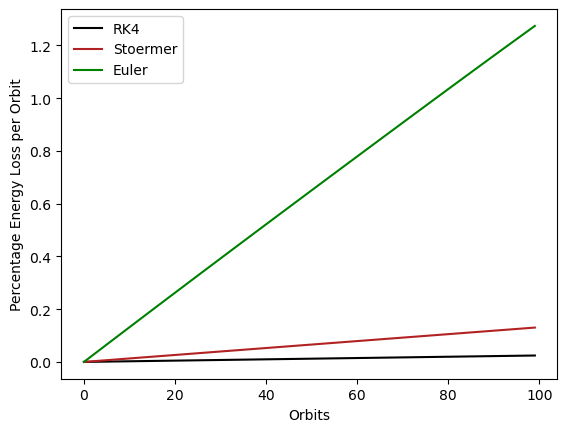

In [21]:
#relative errors to compare these three across orbits 
plt.plot(orbit,ErrorRK4,c='k',lw=1.5,label='RK4')
plt.plot(orbit,ErrorSto,c='firebrick',lw=1.5,label='Stoermer')
plt.plot(orbit,ErrorEul,c='g',lw=1.5,label='Euler')

plt.xlabel('Orbits')
plt.ylabel('Percentage Energy Loss per Orbit')
plt.legend()
plt.show()

### Energy loss within first orbit 

In [22]:
#calculating energy loss across one orbit within itself. We do this for first orbit
def loss_calc(x,y,vx,vy):
    E=0.5* (vx**2 + vy**2)-G*M/np.sqrt(x**2 + y**2)
    Eloss=np.zeros(len(x))
    for i in range(len(x)):
        Eloss[i]=abs((E[0]-E[i])/E[0])*100
    
    return Eloss

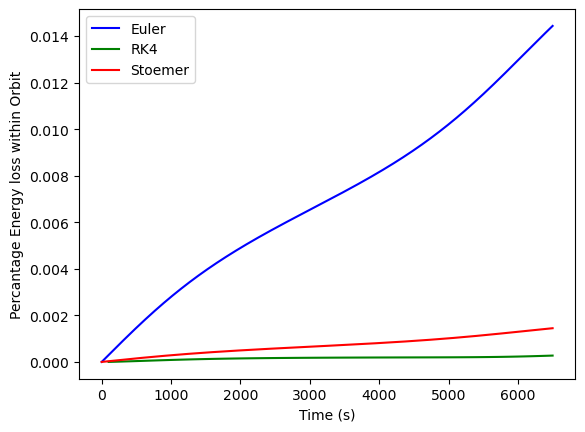

In [23]:
#Euler
Euloss=loss_calc(xu,yu,vxu,vyu)
#RK4
RKloss=loss_calc(x,y,vx,vy)
#Stoermer
Stloss=loss_calc(x1,y1,vx1,vy1)

plt.plot(timeu,Euloss,c='blue',label='Euler')
plt.plot(time,RKloss,c='g',label='RK4')
plt.plot(t1,Stloss,c='red',label='Stoemer')
plt.xlabel('Time (s)')
plt.ylabel('Percantage Energy loss within Orbit')
plt.legend()

## Discussion of the Methods

The best method of integration was found to be RK4 which pose minimal errors in its implementation, stoemer comes a close second while euler is the one with biggest error. However there are several things that can be deduced. The first thing to notice is that the value of energy in stoemer is the best for the single orbit energy loss however as more and more orbits are computed the error becomes higher in stoemer compared to the other methods. This means that it is picking up errors perhaps when calculating each term in the loop. In term of time, because of the iterative nature of stoemer, it takes the longest to integrate, almost 10 times as long as it takes for RK4 to do the same for certain values of H. Euler method takes the least ammount of time. To attain the accuracy of 0.1 percent within 100 orbits, we realise that stoemer requires much lesser H values to evaluate (perhaps because of the errors that accumulate on the way) in comparison to RK4 which works robustly even with values of h upto 100 or 200. 

## Increasing the Speed at Perigee Every Alternate Perigee Passage (Once in two Periods)

### This section is solved using RK4

This problem was solved by integrating the Kepler Equation Orbit by Orbit. In order to do this we solve for the time period using Kepler's law. This gives us the time for which we should integrate our first orbit. Once we have reached that 'Time' we are sure that we have reached approximately near the perigee since we began with it. Now for the integral of the next orbit, we begin with the parameters of the previous orbit such that if the orbit is odd then we leave the parameters as they are, but if it is even, then we increase the velocity of the spaceship by 1 km/s. We expect this to work for 5 orbits if we begin with 8 km/s since after the 4th orbit, our velocity would exceed 11 km/s- the escape velocity of the earth, which would mean that our path will no longer be a closed ellipse and the time period would be higher and higher for every subsequent orbit. This implementation uses the RK4 method of integration and uses the following analytic expressions to estimate time period and semi major axis: 

$$v_p=\sqrt{2GM\left(\frac{1}{2r_p}-\frac{1}{2a}\right)}$$

$$\therefore a=\frac{GMr_p}{2GM-v_p^2r_p}$$

Hence from Kepler's law: 

$$T=2\pi\sqrt{\frac{a^3}{GM}}$$

The initial condition was $r_p=6678$ km and $v_p=v_y=8$ km/s

In [24]:
def find_a(v_p,r_p):
    G=6.67430e-11 #Gravitational constant
    M=5.972e24 #Mass of the Earth 
    a=(G*M*r_p/(2*G*M-v_p**2*r_p))
    return abs(a)
    
def find_T(a):
    G=6.67430e-11 #Gravitational constant
    M=5.972e24 #Mass of the Earth 
    T=2*np.pi*np.sqrt(a**3/(G*M))
    return abs(T)


In [25]:
N=100_00# fix number of points for each orbit
ORB=6 #until it reaches escape velocity: Number of orbits to simulate for. 

def f(r, t): #takes the vector r comprising of velocities and positions
        x = r[0] #the first component gives cartesian coordinate x
        y=r[1] #the second coordinate gives cartesian coordinate y
        r2=(x**2+y**2) #calculate the square of radius
        G=6.67430e-11 #Gravitational constant
        M=5.972e24 #Mass of the Earth 
        a_x=-G*M*x/r2**(1.5) #acceleration in x direction
        a_y=-G*M*y/r2**(1.5) #acceleration in y direction
        vx=r[2] #x-velocity taken from r vector
        vy=r[3] #y-velocity taken from r vector
        dxdt=vx #defining first order DE
        dydt=vy #First order DE
        dvydt=a_y #solving for velocities
        dvxdt=a_x #solving for velocities
        return np.array([dxdt,dydt,dvxdt,dvydt], dtype=float)

k=0 #count of orbits initially
r=[6678000,0,0,8000]
xpos=np.zeros((ORB,N)) #to store each orbit seperately
ypos=np.zeros((ORB,N))
while k<ORB:
#Initializing empty arrays
    a=find_a(r[3],r[0])
    T=find_T(a)
    h=T/N
    time=np.zeros(N)
    x=np.zeros(N)
    y=np.zeros(N)
    vx=np.zeros(N)
    vy=np.zeros(N)

    #Coordinates chosen such that the centre is earth.

    ##RK4 implementation
    for i in range(N):
        time[i]= time[i-1]+h #create a time array
        x[i]=(r[0]) #add to position array x
        y[i]=(r[1]) #add to position array y
        vx[i]=(r[2]) #add to x-velocity
        vy[i]=(r[3]) #add to y-velocity
        #Implementation of RK4 Rules:
        k1 = h * f(r, time[i]) 
        k2 = h * f(r + 0.5 * k1, time[i] + 0.5 * h)
        k3 = h * f(r + 0.5 * k2, time[i] + 0.5 * h)
        k4 = h * f(r + k3, time[i] + h)
        r  += (k1 + 2 * k2 + 2 * k3 + k4) / 6
    # check orbit number
    if k%2==0:
        xpos[k]=x #add to orbit array
        ypos[k]=y
        r = np.array([x[-1],y[-1],vx[-1],vy[-1]+1000], dtype=float) #update initial conditions for next array
    
    else:
        xpos[k]=x
        ypos[k]=y
        r = np.array([x[-1],y[-1],vx[-1],vy[-1]], dtype=float)
    
    k+=1
     

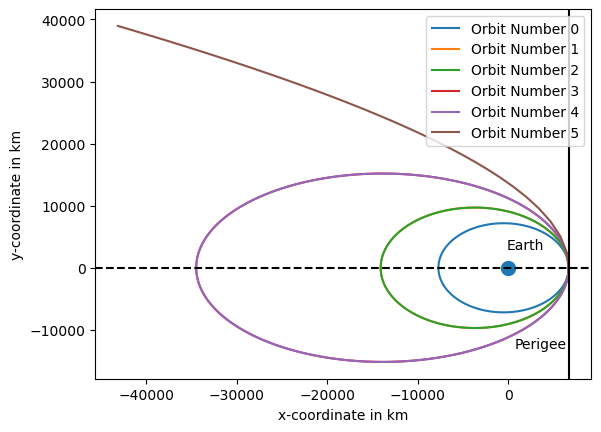

In [26]:
#plot orbit by orbit
for i in range(ORB-1):
    strin='Orbit Number '+str(i)
    plt.plot(xpos[i]/1000,ypos[i]/1000,label=strin)

plt.plot(xpos[ORB-1][:45]/1000,ypos[ORB-1][:45]/1000,label='Orbit Number 5')
plt.axhline(0,ls='--',c='k')
plt.xlabel('x-coordinate in km')
plt.ylabel('y-coordinate in km')
plt.axvline(6678,0,c='k')
plt.text(650,-13000,'Perigee')
plt.scatter(0,0,marker='o',s=100)
plt.text(-200,3000,'Earth')
plt.legend()
plt.show()

The velocity at the 5th orbit exceeds the escape velocity of planet earth (greater than 11km/s) which means that the orbit is no longer stable, as seen by the diverging trajectory of the 5th orbit. The subsequent orbits do not form closed loops. Note that in this coordinate system the perigee is denoted at $6678$ while the apogee takes the negative coordinates in x